In [30]:
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from os import listdir

In [63]:
measure2index={"x-coordinate":0,"y-coordinate":1,"timestamp":2, "button_status":3,"pressure":4, "tilt":5,"elevation":6}
index2measure=list(measure2index.keys())

task2index={"spiral":0,"l":1,"le":2 ,"les":3,"lektorka" :4,"porovnat":5,"nepopadnout":6, "tram":7}
index2task=list(task2index.keys())

In [29]:
index2measure

['x-coordinate',
 'y-coordinate',
 'timestamp',
 'button_status',
 'pressure',
 'tilt',
 'elevation']

In [64]:
index2task

['spiral', 'l', 'le', 'les', 'lektorka', 'porovnat', 'nepopadnout', 'tram']

In [33]:
data_path=join("..","PaHaW","PaHaW_public")#/00026/00026__1_1.svc"
folder_path=listdir(data_path)
folder_path.sort()

In [44]:
task_path=listdir(join(data_path,folder_path[0]))
task_path.sort()

In [45]:
task_path

['00001__1_1.svc',
 '00001__2_1.svc',
 '00001__3_1.svc',
 '00001__4_1.svc',
 '00001__5_1.svc',
 '00001__6_1.svc',
 '00001__7_1.svc',
 '00001__8_1.svc']

In [50]:
raw=[]
for folder in folder_path:
    subject=[]
    task_path=listdir(join(data_path,folder))
    task_path.sort()
    for task in task_path:
        tasks=[]
        path=join(data_path,folder,task)
        with open(path) as file:
            for line in file.readlines():
                tasks.append(line.split())
            tasks.pop(0)
        subject.append(tasks)
    raw.append(subject)

In [55]:
print("(75 subjects, 8 tasks, X task duration/200, 7 recorded signals)")
print(len(raw),len(raw[0]),len(raw[0][0]),len(raw[0][0][0]))

(75 subjects, 8 tasks, X task duration/200, 7 recorded signals)
75 8 1772 7


spiral


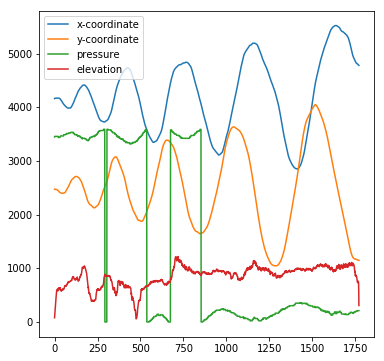

In [72]:
print(index2task[0])
task=np.asarray(raw[0][0],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

l


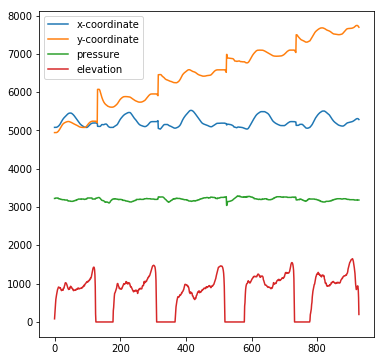

In [73]:
j=1
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

le


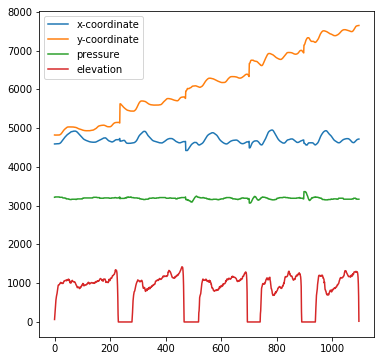

In [74]:
j=2
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

les


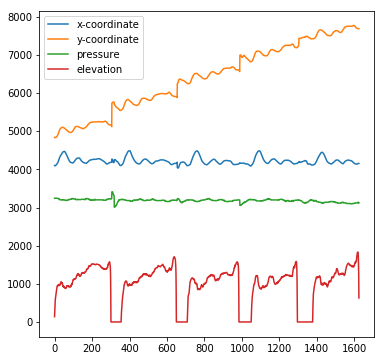

In [75]:
j=3
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

lektorka


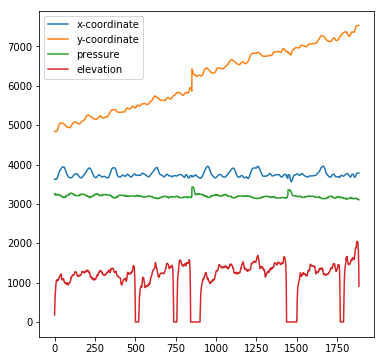

In [76]:
j=4
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

porovnat


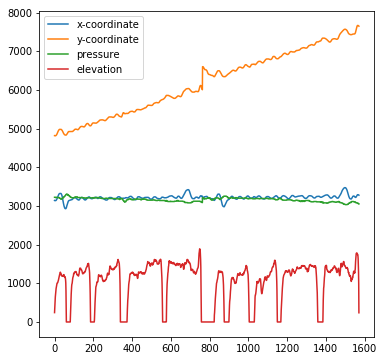

In [77]:
j=5
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

nepopadnout


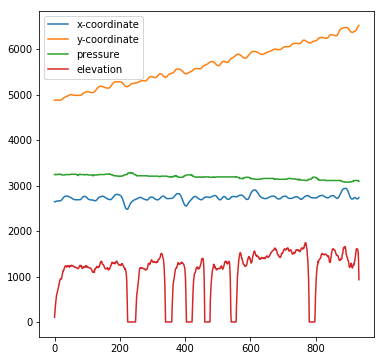

In [78]:
j=6
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.figure(figsize=(6,6))
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

tram


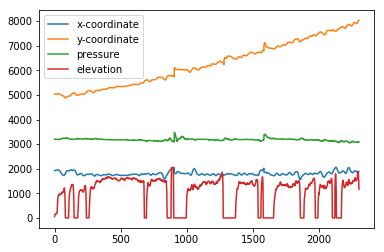

In [91]:
j=7
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
for i in [0,1,4,6]:
    plt.plot(task[:,i],label=index2measure[i])
    plt.legend()

spiral


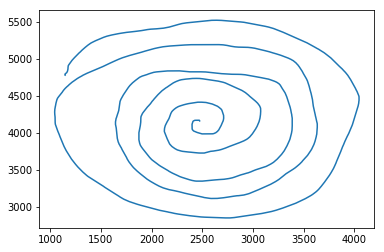

In [92]:
j=0
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

l


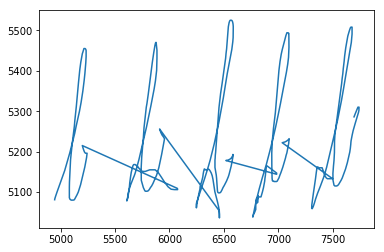

In [95]:
j=1
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

le


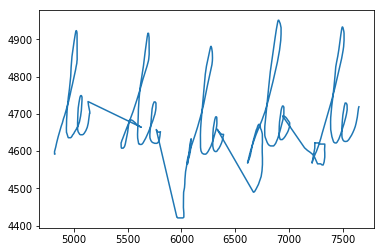

In [96]:
j=2
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

les


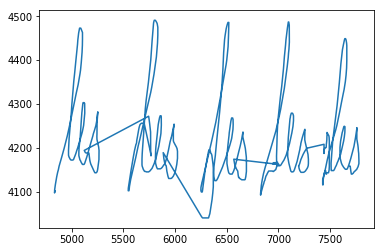

In [97]:
j=3
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

lektorka


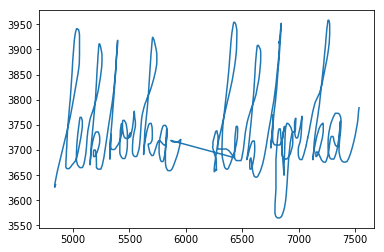

In [98]:
j=4
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

porovnat


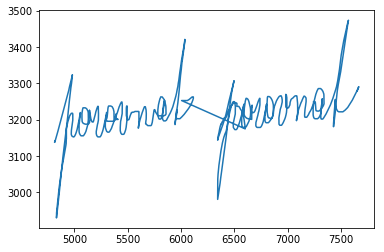

In [99]:
j=5
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

nepopadnout


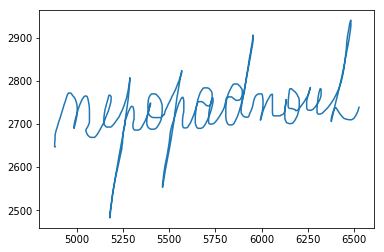

In [100]:
j=6
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

tram


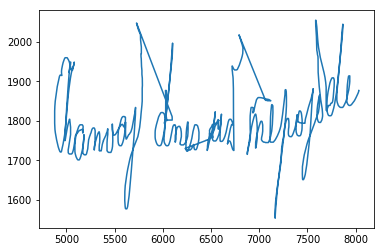

In [102]:
j=7
print(index2task[j])
task=np.asarray(raw[0][j],dtype=int)
plt.plot(task[:,1],task[:,0])

In [59]:
task

array([  4161,   2474, 625877,      1,   3447,    633,     78])

In [20]:
raw[:,0]

array([4043, 4044, 4044, ..., 5135, 5140, 5145])

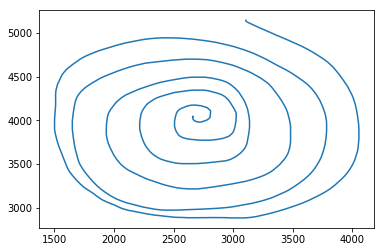

In [23]:
plt.plot(raw[:,1],raw[:,0])